# Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# File import

In [2]:
cleavage = pd.read_excel(
    'Cleavage positions.xlsx', 
    sheet_name = 'wtCas9_sgRNA1', 
    skiprows = 1, 
   # index_col = [0])
).replace('None', np.nan)
no_log = cleavage.drop('cleavage_rate_log', axis = 'columns').drop('cleavage_rate_log_unc', axis = 'columns').drop('descriptor', axis = 'columns')
cleavage_rate = cleavage.loc[:, 'sequence':'cleavage_rate_log_unc'].drop('descriptor', axis = 'columns')

In [3]:
cleavage_rate

sequence  cleavage_rate_log  cleavage_rate_log_unc
0       TTTAGACCCATAAAGATAAGACGCTGG          -2.977889               0.123122
1       TTTAGACGCTTAAAGATGAGAGGCTGG          -4.521508               0.128360
2     TTTAGGAACGCATAAAGATGAGACGCTGG          -0.844324               0.081633
3     TTTAGACGCATAAAGATGAGACGCGTCCA          -5.164886               2.005390
4     TTTAGACGCATAAAGATGAGACGCGTCCG          -5.822938               0.262783
...                             ...                ...                    ...
9952    TTTAGACGCACAAAGATGACACGCTGG          -4.865986               0.295606
9953    TTTAGACGCATAAAGATGACACGCTGG          -3.723213               0.077379
9954  AGCGTTGACGCATAAAGATGAGACGCTGG          -0.863172               0.065296
9955    TTTAGACGCATAAAGATGAGACGCCGC          -5.104417               0.125504
9956    TTTAGACGCATAAAGATGAGACGCCGA          -3.916725               0.121850

[9957 rows x 3 columns]

# Features of the main sequence

In [4]:
pam_cas12 = 'TTTA'
pam_cas9 = 'TGG'
sequence = 'GACGCATAAAGATGAGACGC'

In [5]:
OG_seq = cleavage[cleavage['sequence'] == pam_cas12 + sequence + pam_cas9]
OG_seq

sequence descriptor  cleavage_rate_log  \
4819  TTTAGACGCATAAAGATGAGACGCTGG     pamTGG          -1.032424   

      cleavage_rate_log_unc  L_12s  L_3m  L_10m  L_100m  L_300m  L_1000m  \
4819               0.075517    3.0   3.0    3.0     3.0     3.0      3.0   

      L_3000m  R_12s  R_3m  R_10m  R_100m  R_300m  R_1000m  R_3000m  
4819      NaN    3.0   3.0    3.0     3.0     3.0      3.0      NaN

# Creating Filters

In [6]:
def create_mismatches(sequence, pam_5_end='', pam_3_end=''):
    # When given a sequence, will generate all possible single and double mismatches
    # Can also add two PAMs on different ends
    mis_list = []
    
    # Single mismatches
    for i in range(len(sequence)):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base + sequence[i+1:] + pam_3_end
            #adds the base into a defined sequence, skipping the place where it gets added, that way simulating a mismatch
            mis_list.append(new_seq)

            # Double mismatches
            for j in range(i+1, len(sequence)):
                for base2 in 'ACGT':
                    new_seq2 = pam_5_end + sequence[:i] + base + sequence[i+1:j] + base2 + sequence[j+1:] + pam_3_end
                    mis_list.append(new_seq2)
                    
                    # Triple mismatches
                    #for f in range(i+2, len(sequence)):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base + sequence[i+1:j] + base2 + sequence[j+1:f] + base3 + sequence[f:] + pam_3_end
                            #mis_list.append(new_seq3)
    return mis_list
   
mismatch = create_mismatches(sequence, 'TTTA', 'TGG')

In [7]:
def create_del(sequence, pam_5_end = '', pam_3_end = ''):
    # When given a sequence, will generate all possible single, double, and triple deletions
    del_list = []
    
    # Single deletions
    for i in range(len(sequence)):
        new_seq = sequence[:i] + sequence[i+1:]
        del_list.append(new_seq)

        # Double deletions
        for j in range(i+1, len(sequence)):
            new_seq = sequence[:i] + sequence[i+1:j] + sequence[j+1:]
            #skipps one base, that way making a deletion
            del_list.append(new_seq)

            # Triple deletions
            #for k in range(j+1, len(sequence)):
                #new_seq = sequence[:i] + sequence[i+1:j] + sequence[j+1:k] + sequence[k+1:]
                #del_list.append(new_seq)

    return del_list

dels = create_del(sequence, 'TTTA', 'TGG')

In [8]:
def create_ins(sequence, pam_5_end = '', pam_3_end = ''):
    # When given a sequence, will generate all possible single, double, and triple insertions
    # Can also add two PAMs on different ends
    ins_list = []
    
    #Single insertion
    for i in range(len(sequence)+1):
        for base1 in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base1 + sequence[i:] + pam_3_end
            #adds a base 
            ins_list.append(new_seq)
            
            #Double insertion
            for j in range(i+1, len(sequence)+2):
                for base2 in 'ACGT':
                    new_seq2 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:] + pam_3_end
                    ins_list.append(new_seq2)
                    
                    #Triple insertion
                    #for k in range(j+1, len(sequence)+3):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:k] + base3 + sequence[k:] + pam_3_end
                            #ins_list.append(new_seq3)
    return ins_list

ins = create_ins(sequence, 'TTTA', 'TGG')

In [9]:
def create_small_ins(sequence, pam_5_end = '', pam_3_end = ''):
    #Will create insertions in a given sequence only at position 3 and 4 from the 3' end
    ins_list = []
    
    #Single insertion
    for i in range(-3, -1):
        for base1 in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base1 + sequence[i:] + pam_3_end
            ins_list.append(new_seq)
            
            #Double insertion
          #  for j in range(i+1, i+2):
           #     for base2 in 'ACGT':
            #        new_seq2 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:] + pam_3_end
             #       ins_list.append(new_seq2)
                    
                    #Triple insertion
                    #for k in range(j+1, len(sequence)+3):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:k] + base3 + sequence[k:] + pam_3_end
                            #ins_list.append(new_seq3)
    return ins_list

small_ins = create_small_ins(sequence, 'TTTA', 'TGG')

In [10]:
def double_base(sequence, pam_5_end = '', pam_3_end = ''):
    double_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+1]+sequence[x:] + pam_3_end
        double_seq.append(new_seq)
        
    return double_seq

double_base = double_base(sequence, 'TTTA', 'TGG')

In [11]:
def triple_base(sequence, pam_5_end = '', pam_3_end = ''):
    triple_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+1] + sequence[x:x+1] + sequence[x:] + pam_3_end
        triple_seq.append(new_seq)
        
    return triple_seq

triple_bases = triple_base(sequence, 'TTTA', 'TGG')

In [12]:
def rep2_tribase(sequence, pam_5_end = '', pam_3_end = ''):
    triple_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+2]+sequence[x:] + pam_3_end
        triple_seq.append(new_seq)
        
    return triple_seq

rep_base = rep2_tribase(sequence, 'TTTA', 'TGG')

# Filtering Data

In [13]:
ins_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)

small_ins_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)

mis_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)

del_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)

doubles_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)

triples_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)

rep2_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)

#quatro_df = pd.DataFrame(
 #   columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
#)

In [14]:
#Fill the empty dataframes with data from created filters
#If running this cell with triple mismatches and more features, be ready to wait for at least 5 minutes

for seq in ins:
    matching_rows = no_log[no_log['sequence'] == seq]
    ins_df = pd.concat([ins_df, matching_rows])

for seq in small_ins:
    matching_rows = no_log[no_log['sequence'] == seq]
    small_ins_df = pd.concat([small_ins_df, matching_rows])
    
for seq in dels:
    matching_rows = no_log[no_log['sequence'] == seq]
    del_df = pd.concat([del_df, matching_rows])
    
for seq in mismatch:
    matching_rows = no_log[no_log['sequence'] == seq]
    mis_df = pd.concat([mis_df, matching_rows])
    
for seq in double_base:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    doubles_df = pd.concat([doubles_df, matching_rows])
    
for seq in triple_bases:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    triples_df = pd.concat([triples_df, matching_rows])
    
for seq in rep_base:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    rep2_df = pd.concat([rep2_df, matching_rows])
    
#for seq in quatro_bases:
  #  matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
   # quatro_df = pd.concat([quatro_df, matching_rows])

# Visualization of Cut sites at one time point 

In [15]:
def swarm_data(df, column):
    
    #Will put the values from the column into a seperate dataframe based on the position of the bases and what base it is
    
    new_df = pd.DataFrame()

    data_df = df.dropna(subset=[column])

    for x in range(-7, -5):
        for base in 'ACGT':
            mask = (data_df['sequence'].str[x] == base)
            #will check each base in each of the defined positions 
            new_column_name = f'{abs(x)-3}{base}{abs(x)-4}'
            #names the column
            new_df[new_column_name] = data_df.loc[mask, column].reset_index(drop=True)
            #drop the data into the labeled column
    new_df = new_df.fillna(0)

    return new_df

In [16]:
def nona_count(df, column):
    
    #Counts how many non NaN values are in each column 
    
    new_df = pd.DataFrame()

    data_df = df.dropna(subset=[column])

    for x in range(-7, -5):
        for base in 'ACGT':
            mask = (data_df['sequence'].str[x] == base)
            new_column_name = f'{abs(x)-3}{base}{abs(x)-4}'
            new_df[new_column_name] = data_df.loc[mask, column].reset_index(drop=True)
        
    nona_count = new_df.notna().sum()
    return nona_count

In [17]:
def mean_df(df, column):
    
    #Will create a dataframe of average values for each column. This later is used in graph drawing
    
    mean_df = pd.DataFrame()

    for x in range(-7, -5):  #For each position 3 and 4
        for base in 'ACGT':  #Take a base
            notna_df = df[df[column].notna()]   #Filter the data that this column contains no NaN values
            average_cut = notna_df[notna_df['sequence'].str[x] == base][column].mean()   #find the sequences that contain that specific base in that specific position in that column
            column_name = f'{abs(x)-3}{base}{abs(x)-4}'   #Name the column of the empty dataframe
            mean_df.loc[0, column_name] = average_cut
    
    return mean_df

In [18]:
def mean_swarm(swarm, column, save = '', name = 'swarm with mean'):    
    
    #Will draw a strip plot of DNA cut sites, where a distribution of an average cut location based on the base in a certain position
    #will be depicted
    
    fig = plt.figure(figsize=(10, 7))
    sns.stripplot(data=swarm_data(swarm, column), orient="v", palette="Set2", size = 16, dodge=False, alpha = 0.3)
    #plt.scatter(x = mean_df(swarm, column).columns, y = mean_df(swarm, column), marker = 'o', color = 'black', s = 10, zorder = 10)
    plt.ylim(1.8, 4.2)
    plt.axhline(2, color='grey', alpha = 0.5)
    plt.axhline(2.5, color='grey', alpha = 0.5, linestyle=':')
    plt.axhline(3, color='grey', alpha = 0.5)
    plt.axhline(3.5, color='grey', alpha = 0.5, linestyle=':')
    plt.axhline(4, color='grey', alpha = 0.5)
    #plt.xlabel('Position and base')
    plt.ylabel('Average cut site at 1000 minute time point')
    plt.title('Cut site position in sequences with a single insertion')

    y_offset = 0.1
    for pos, count in enumerate(nona_count(swarm, column)):
        plt.text(pos - 0.2, 1.4 + y_offset, f'n = {count}')
    
    if save == 'yes':
        plt.savefig(f"PNG {name}.png")
        plt.savefig(f'SVG {name}.svg', format='svg', bbox_inches='tight')

In [19]:
swarm_data(small_ins_df, 'L_1000m')

4A3  4C3  4G3  4T3  3A2   3C2   3G2  3T2
0  3.09  4.0    0  4.0  4.0  3.09  3.52  4.0

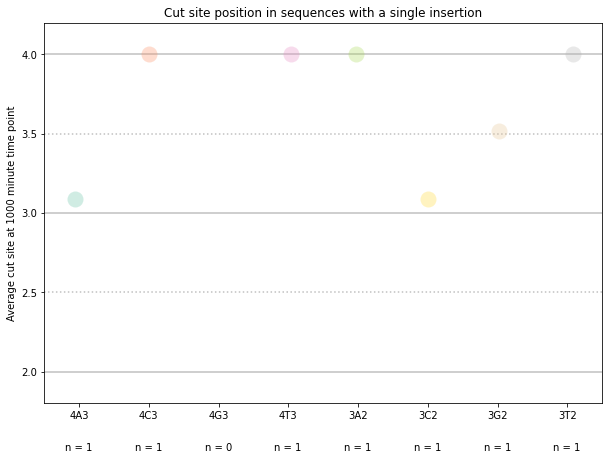

In [20]:
mean_swarm(small_ins_df, 'L_1000m')

In [21]:
small_ins_df

sequence L_12s  L_3m L_10m L_100m L_300m L_1000m  \
1142  TTTAGACGCATAAAGATGAGAACGCTGG   NaN   NaN   3.5   3.45   3.33    3.09   
9859  TTTAGACGCATAAAGATGAGACCGCTGG   NaN   NaN   NaN    NaN    NaN     4.0   
9037  TTTAGACGCATAAAGATGAGAGCGCTGG   NaN   NaN   NaN    NaN    NaN     NaN   
6355  TTTAGACGCATAAAGATGAGATCGCTGG   NaN   NaN   NaN    NaN    NaN     4.0   
2445  TTTAGACGCATAAAGATGAGACAGCTGG   NaN   NaN   NaN    4.0    4.0     4.0   
9859  TTTAGACGCATAAAGATGAGACCGCTGG   NaN   NaN   NaN    NaN    NaN     4.0   
4850  TTTAGACGCATAAAGATGAGACGGCTGG   NaN  3.57  3.43   3.55   3.48    3.52   
9406  TTTAGACGCATAAAGATGAGACTGCTGG   NaN   NaN   NaN    4.0    4.0     4.0   

     L_3000m R_12s  R_3m R_10m R_100m R_300m R_1000m R_3000m  
1142     NaN   NaN   NaN   NaN    3.0    3.0     3.0     NaN  
9859     NaN   NaN   NaN   NaN    3.0    3.0     3.0     NaN  
9037     NaN   NaN   NaN   NaN    NaN    NaN     NaN     NaN  
6355     NaN   NaN   NaN   NaN    NaN    NaN    3.04     NaN  
2445     NaN   NaN   NaN   NaN   3.33   3.22    3.15     NaN  
9859     NaN   NaN   NaN   NaN    3.0    3.0     3.0     NaN  
4850     NaN   NaN  3.63  3.58   3.36   3.12    3.09     NaN  
9406     NaN   NaN   NaN   NaN   3.15   3.09    3.08     NaN

# Visualization of change in Cut site location based on time 

In [22]:
def cut_kinetics(
    df, 
    column_start_name = 'sequence', 
    column_end_name = 'L_3000m', 
    ylim = [2.7, 4.2], 
    figsize = [10, 5]):

    # Will draw the kinetics of a nuclease 
    
    
    titles = []
    row_end = len(df)
    for x in range(-7, -5):
        for base in 'ACGT':
            new_title = f'Insertion at position {abs(x)-3}{base}'
            titles.append(new_title)

    cut_df = df.loc[:, column_start_name:column_end_name]
    trans_df = cut_df.transpose()

    for x in range(0, len(cut_df)):
        column = trans_df.columns[x]  # get the column name instead of its contents
        data = trans_df[column].iloc[1:].dropna()  # drop NaN values in the column
        plt.figure(figsize = figsize)
        plt.plot(data)
        plt.scatter(x = trans_df.iloc[1:, x].index, y = trans_df.iloc[1:, x])
        plt.title(titles[x], size = 17)
        plt.ylabel('Average cut site', size = 15)
        plt.xlabel('Time point', size = 15)
        plt.ylim(ylim)
        plt.axhline(2, color='grey', alpha = 0.5)
        plt.axhline(2.5, color='grey', alpha = 0.5, linestyle=':')
        plt.axhline(3, color='grey', alpha = 0.5)
        plt.axhline(3.5, color='grey', alpha = 0.5, linestyle=':')
        plt.axhline(4, color='grey', alpha = 0.5)

C:\Users\justa\AppData\Local\Temp\ipykernel_28664\1689142584.py:26: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(x = trans_df.iloc[1:, x].index, y = trans_df.iloc[1:, x])


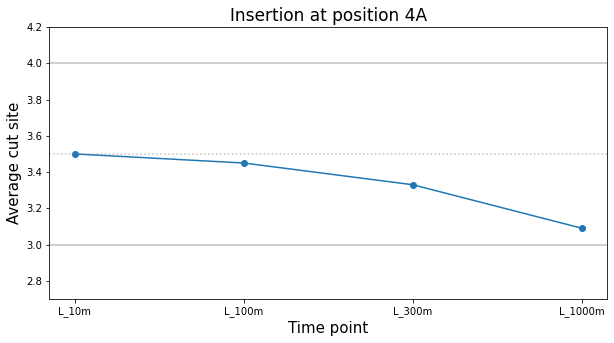

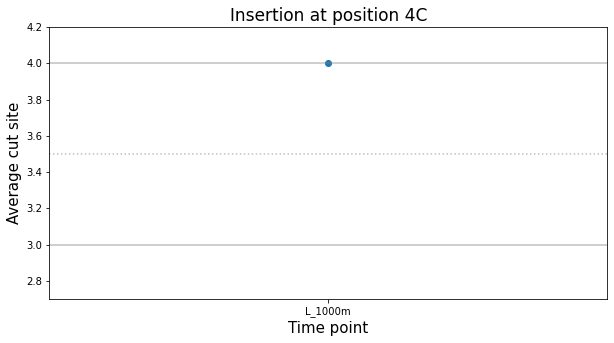

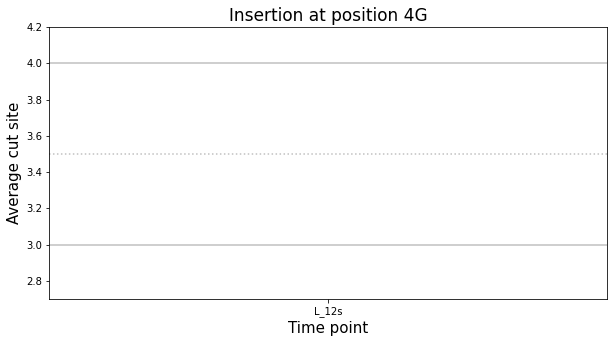

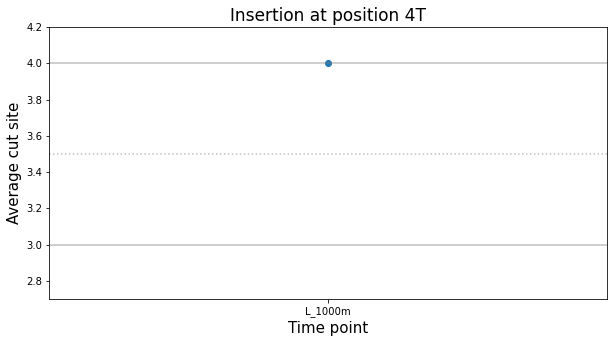

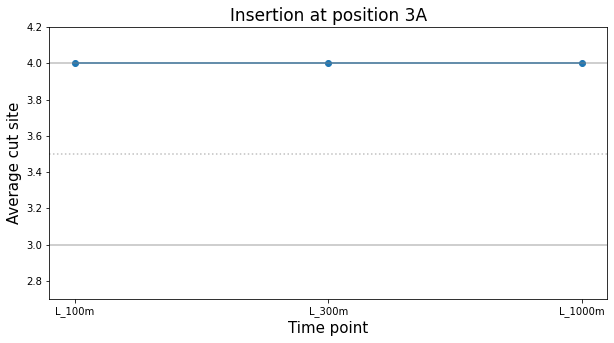

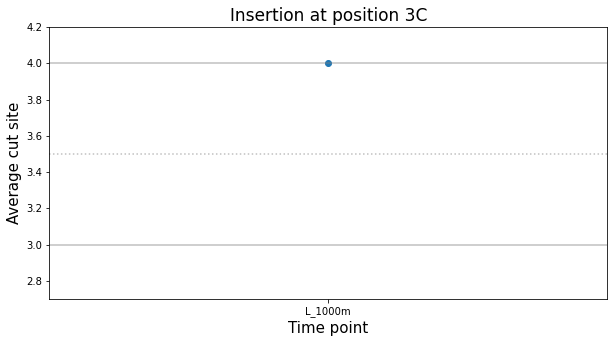

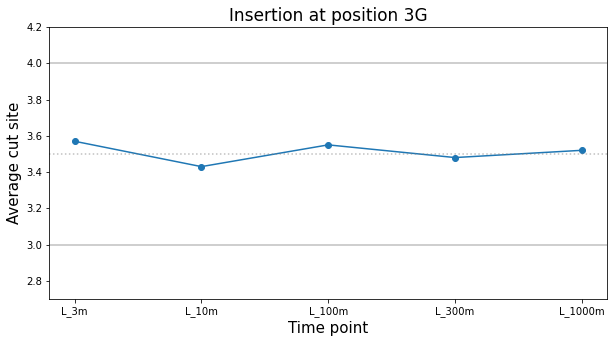

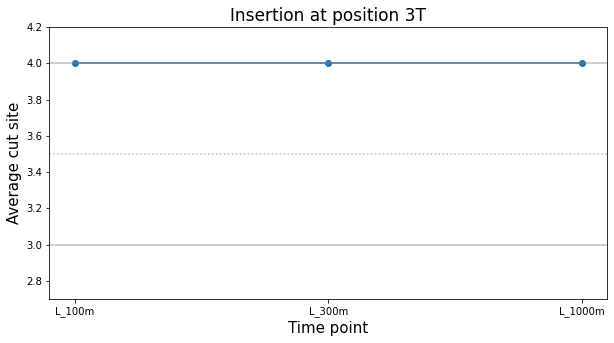

In [23]:
cut_kinetics(small_ins_df)

# Visualization of cut rate changes based on where a duplicated sequence is placed

In [24]:
cleavage[cleavage['sequence'].str.contains(f'^TTTA{sequence}TGG$')]

sequence descriptor  cleavage_rate_log  \
4819  TTTAGACGCATAAAGATGAGACGCTGG     pamTGG          -1.032424   

      cleavage_rate_log_unc  L_12s  L_3m  L_10m  L_100m  L_300m  L_1000m  \
4819               0.075517    3.0   3.0    3.0     3.0     3.0      3.0   

      L_3000m  R_12s  R_3m  R_10m  R_100m  R_300m  R_1000m  R_3000m  
4819      NaN    3.0   3.0    3.0     3.0     3.0      3.0      NaN

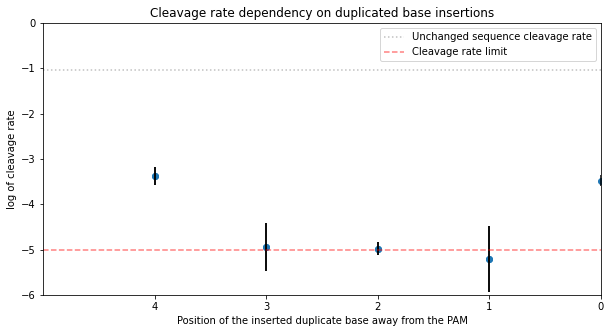

In [25]:
def cut_rate(df, x_axis='sequence', y_axis='cleavage_rate_log', y_error='cleavage_rate_log_unc', save = '', name = 'single cleavage rate'):
    
    #Creates the cleavage rate graph for a single data set 
    
    df = df.reset_index(drop=True)
    
    plt.figure(figsize=[10, 5])
    plt.scatter(x=df.loc[:, x_axis], y=df.loc[:, y_axis])
    plt.errorbar(x=df.loc[:, x_axis], y=df.loc[:, y_axis], yerr=df.loc[:, y_error], fmt='none', color = 'black')
    
    plt.axhline(-1.032424, color='grey', alpha = 0.5, linestyle = ':', label = 'Unchanged sequence cleavage rate')
    plt.axhline(-5, color='red', alpha = 0.5, linestyle = '--', label = 'Cleavage rate limit')
    
    tick_labels = ['{}'.format(len(df)-2-2-1-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(df)), tick_labels)
    
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the inserted duplicate base away from the PAM')
    plt.title('Cleavage rate dependency on duplicated base insertions')
    
    plt.xlim(-1, len(df)-4-1)
    plt.ylim(-6, 0)
    plt.legend()
    
    if save == 'yes':
        plt.savefig(f"PNG {name}.png")
        plt.savefig(f'SVG {name}.svg', format='svg', bbox_inches='tight')

cut_rate(rep2_df)

df_sequence df_cleavage_rate_log  \
0   TTTAGGACGCATAAAGATGAGACGCTGG            -1.050486   
1   TTTAGAACGCATAAAGATGAGACGCTGG            -0.783183   
2   TTTAGACCGCATAAAGATGAGACGCTGG            -0.847354   
3   TTTAGACGGCATAAAGATGAGACGCTGG            -0.970217   
4   TTTAGACGCCATAAAGATGAGACGCTGG             -2.40417   
5   TTTAGACGCAATAAAGATGAGACGCTGG            -2.567038   
6   TTTAGACGCATTAAAGATGAGACGCTGG             -3.68927   
7   TTTAGACGCATAAAAGATGAGACGCTGG             -1.64033   
8   TTTAGACGCATAAAAGATGAGACGCTGG             -1.64033   
9   TTTAGACGCATAAAAGATGAGACGCTGG             -1.64033   
10  TTTAGACGCATAAAGGATGAGACGCTGG            -3.662997   
11  TTTAGACGCATAAAGAATGAGACGCTGG            -4.078085   
12  TTTAGACGCATAAAGATTGAGACGCTGG            -3.543061   
13  TTTAGACGCATAAAGATGGAGACGCTGG            -3.087522   
14  TTTAGACGCATAAAGATGAAGACGCTGG            -2.925021   
15  TTTAGACGCATAAAGATGAGGACGCTGG            -2.928021   
16  TTTAGACGCATAAAGATGAGAACGCTGG            -4.012576   
17  TTTAGACGCATAAAGATGAGACCGCTGG            -3.706724   
18  TTTAGACGCATAAAGATGAGACGGCTGG            -2.075225   
19  TTTAGACGCATAAAGATGAGACGCCTGG            -3.479814   

   df_cleavage_rate_log_unc                   df1_sequence  \
0                  0.124431  TTTAGGGACGCATAAAGATGAGACGCTGG   
1                  0.052413  TTTAGAAACGCATAAAGATGAGACGCTGG   
2                   0.09288  TTTAGACCCGCATAAAGATGAGACGCTGG   
3                  0.069714  TTTAGACGGGCATAAAGATGAGACGCTGG   
4                  0.186061  TTTAGACGCCCATAAAGATGAGACGCTGG   
5                  0.097757  TTTAGACGCAAATAAAGATGAGACGCTGG   
6                  0.188533  TTTAGACGCATTTAAAGATGAGACGCTGG   
7                  0.119706  TTTAGACGCATAAAAAGATGAGACGCTGG   
8                  0.119706  TTTAGACGCATAAAAAGATGAGACGCTGG   
9                  0.119706  TTTAGACGCATAAAAAGATGAGACGCTGG   
10                 0.066711  TTTAGACGCATAAAGGGATGAGACGCTGG   
11                 0.364578  TTTAGACGCATAAAGAAATGAGACGCTGG   
12                 0.114633  TTTAGACGCATAAAGATTTGAGACGCTGG   
13                  0.08866  TTTAGACGCATAAAGATGGGAGACGCTGG   
14                 0.100895  TTTAGACGCATAAAGATGAAAGACGCTGG   
15                 0.126977  TTTAGACGCATAAAGATGAGGGACGCTGG   
16                 0.468802  TTTAGACGCATAAAGATGAGAAACGCTGG   
17                 0.107507  TTTAGACGCATAAAGATGAGACCCGCTGG   
18                 0.146784  TTTAGACGCATAAAGATGAGACGGGCTGG   
19                  0.12057  TTTAGACGCATAAAGATGAGACGCCCTGG   

   df1_cleavage_rate_log df1_cleavage_rate_log_unc  
0              -0.983604                  0.064915  
1              -0.651702                  0.117339  
2              -0.949995                  0.056335  
3              -1.391518                  0.129381  
4               -3.52043                  0.132438  
5              -3.960435                  0.378329  
6              -5.120128                     0.122  
7              -4.949561                  0.532051  
8              -4.949561                  0.532051  
9              -4.949561                  0.532051  
10             -4.973061                   0.20701  
11             -4.944047                   0.12528  
12             -5.301187                  0.211254  
13             -5.032815                  0.306618  
14             -4.923282                  1.897879  
15             -5.027574                  0.141359  
16             -5.329564                  0.175736  
17             -5.311581                  0.220922  
18             -2.643944                  0.145637  
19             -5.330442                  0.272548

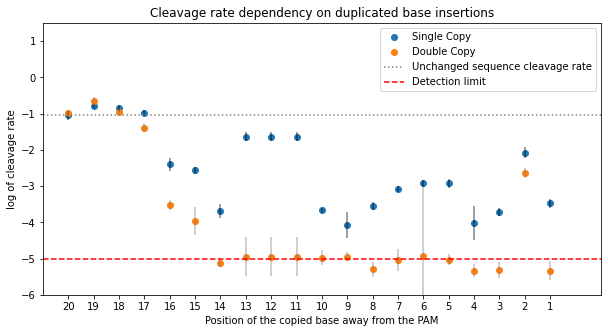

In [26]:
def cut_rate2(df, 
              df1, 
              legend1='Single Copy', 
              legend2='Double Copy', 
              legend3 = 'Unchanged sequence cleavage rate', 
              legend4 = 'Detection limit',
              save = '',
              name = 'sgRNA1'
):
    
    #Takes two dataframes and compares the cleavage rates between them also displaying the uncertainty
    
    df = df.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    j_df = df.add_prefix('df_')
    j_df1 = df1.add_prefix('df1_')
    joint_df = pd.concat([j_df, j_df1], axis=1)
    
    x_data = df.index
    
    plt.figure(figsize=[10, 5])
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], label=legend1)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], label=legend2)
    
    # Add uncertainty bars
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df_cleavage_rate_log_unc'], 
                 linestyle='None', color='black', alpha=0.5)
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df1_cleavage_rate_log_unc'], 
                 linestyle='None', color='grey', alpha=0.5)
    
    tick_labels = ['{}'.format(len(df)-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(joint_df)), tick_labels)
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the copied base away from the PAM')
    plt.title('Cleavage rate dependency on duplicated base insertions')
    
    plt.axhline(-1.032424, color='grey', alpha=1, linestyle=':', label = legend3)
    plt.axhline(-5, color='red', alpha=1, linestyle='--', label = legend4)
    
    plt.xlim(-1, len(joint_df)+1)
    plt.ylim(-6, 1.5)
    plt.legend(loc='best')    
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')
    
    return joint_df

cut_rate2(doubles_df, triples_df)

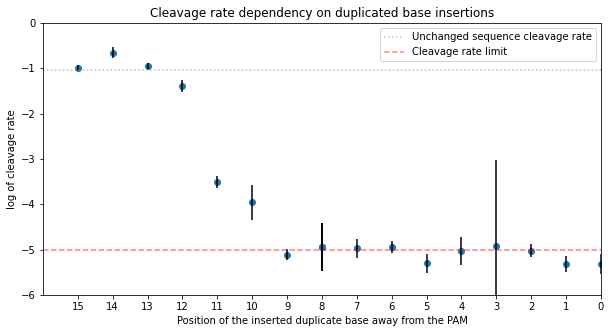

In [27]:
cut_rate(triples_df)

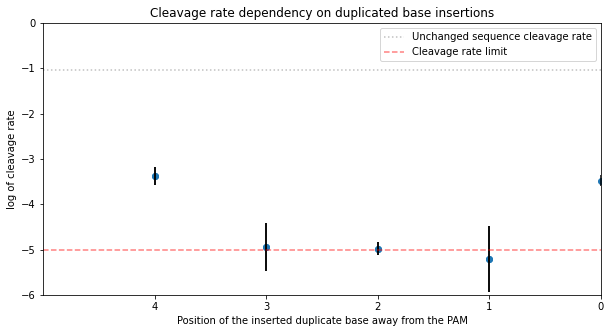

In [28]:
cut_rate(rep2_df)

In [29]:
rep2_df

sequence cleavage_rate_log cleavage_rate_log_unc
9551  TTTAGACGCATATAAAGATGAGACGCTGG         -3.379635              0.206182
9551  TTTAGACGCATATAAAGATGAGACGCTGG         -3.379635              0.206182
8730  TTTAGACGCATAAAAAGATGAGACGCTGG         -4.949561              0.532051
8730  TTTAGACGCATAAAAAGATGAGACGCTGG         -4.949561              0.532051
3807  TTTAGACGCATAAAGAGATGAGACGCTGG         -4.980214              0.139702
3807  TTTAGACGCATAAAGAGATGAGACGCTGG         -4.980214              0.139702
7365  TTTAGACGCATAAAGATGAGACGCGCTGG         -5.202509              0.729243
7365  TTTAGACGCATAAAGATGAGACGCGCTGG         -5.202509              0.729243
7341   TTTAGACGCATAAAGATGAGACGCCTGG         -3.479814               0.12057